# Lesson 5. Uncertainty Analysis

<b>Recommended preliminary knowledge:</b> Knowledge gained in lesson 3 and corresponding recommended preliminary knowledge. Furthermore, the user is encouraged to familiarize themselves with the Python package <i>lmfit</i>, which is useful for performing least-squared optimization.

Development of thermodynamic modelling functions: Xiaodong Liang<br>
Development of optimization functions: Daniel Qvistgaard<br>
Jupyter Notebook author: Daniel Qvistgaard

## 1. Introduction
In lesson 3 comparison functions were introduced. Comparison functions are helpful, because they return the deviation/error between the model and experimental data. In this chapter you will learn about parameter optimization using the CERE package, and at the heart of any parameter optimization is an <i>objective function</i>. Here the objective functions will contain the comparison functions we learned about in lesson 3.

## 2. Initialization
In order for any code blocks to properly work in this Jupyter Notebook, please run the following code block. This piece of code loads the CERE package containing thermodynamical functions. Furthermore, <i>Numpy</i> and <i>matplotlib</i> are loaded.

In [1]:
from scipy.optimize import leastsq
import xThermoInterface as xt #Required
import numpy as np #Recommended
from matplotlib import pyplot as plt #Recommended - used for plotting
import pandas as pd #Recommended

## 3. Loading Data

Here we load pure component data for the compound Triethylene glycol (TEG).

In [2]:
#Here we initialize the class
exp_data = xt.ExpDataModule()

#By using the "Add" class function, we may add experimental data to the class. First we add vapor pressure data
filename_psat = 'experimental_data/TEG_vapor_pressure.csv'
datatype_psat = 'PSat'
identifier_psat = 'teg_psat'
exp_data.Add(filename_psat, datatype_psat, identifier_psat)

#Similarly, we add liquid density data.
filename_rho = 'experimental_data/TEG_liq_density.csv'
datatype_rho = 'rho'
identifier_rho = 'teg_rho'
exp_data.Add(filename_rho, datatype_rho, identifier_rho)



In [3]:
#It is common to limit the pure component data to a specific temperature range, typically expressed as an
#an interval of reduced temperatures. If we seek to remove data outside these region, we impose the interval by 
#using the ReducedTemperature function

Tr_min = 0.4 #Reduced temperature min
Tr_max = 0.9 #Reduced temperature max
Tc = 769.5 #Critical temprature [K]
exp_data.ReducedTemperature(Tr_min, Tr_max, Tc)

print("After adjusting for reduced temperature")
exp_data.Show_list()

After adjusting for reduced temperature
Data Type        Dim (r x c)     Name           
-------------------------------------------------------------
PSat             38x2            teg_psat       
rho              50x2            teg_rho        




## 4. Sensitivity Analysis
Now that we have selected experimental data to use for the sensitivity analyisis, it is time to perform the actual uncertainty analysis. First we set up a CPA model, which is done below

In [4]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = xt.xThermoInterface()

Tc = 769.5
Pc = 33.2
Om = 0.05 #whatever

b0 = 128.93
Gamma = 3622.5
c1 = 0.9100

AssocEng =  1420.0
AssocVol = 20.0
AssocSch = 24

Thermo.NoPureComp(1)
Thermo.CritProps(1,Tc,Pc,Om)
Thermo.CPAParams(1,b0,Gamma,c1)
Thermo.AssocParams(1,AssocSch,AssocVol,AssocEng)

Now that a model have been set up, we can use the CPA_UncertaintyAnalysis class to perform sensitivity analysis.

In [5]:
#First an Uncertainty Analysis object is created
UncertaintyAnalysis = xt.CPA_UncertaintyAnalysis()

#Using the subfunction AddThermo, we can add the previously defined model to the object
UncertaintyAnalysis.AddThermo(Thermo)

#Using the subfunction AddExp, we can add the previously defined experimental data to the object
UncertaintyAnalysis.AddExp(exp_data)

#We are now ready to run sensitivity analysis.
(psat_deviation, rho_deviation, deltas) = UncertaintyAnalysis.Sensitivity_Analysis()

#psat_deviationn: Five column matrix, each column represents the deviations between model and psat data 
#measured at a change in one variable.
#Col 1: b0 [%]
#Col 2: Gamma [%]
#Col 3: c1 [%]
#Col 4: beta [%]
#Col 5: epsr [%]

#deltas: One column vector, each row represents a percent deviation from original parameter value.

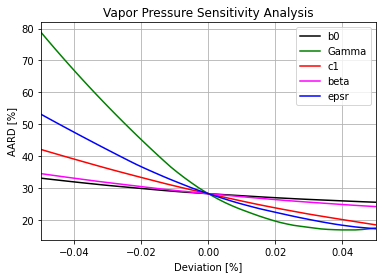

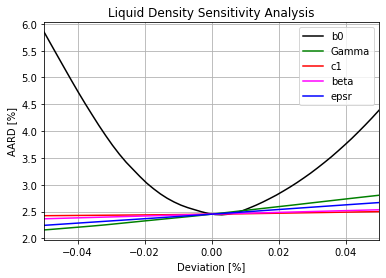

In [6]:
colors = ["black", "green", "red", "magenta",  "blue"]

for i in range(0,5):
    plt.plot(deltas,psat_deviation[:,i],color=colors[i])
plt.xlabel("Deviation [%]")
plt.ylabel("AARD [%]")
plt.legend(["b0", "Gamma", "c1", "beta", "epsr"])
plt.grid()
plt.xlim([np.min(deltas),np.max(deltas)])
plt.title("Vapor Pressure Sensitivity Analysis")
plt.show()

for i in range(0,5):
    plt.plot(deltas,rho_deviation[:,i],color=colors[i])
plt.xlabel("Deviation [%]")
plt.ylabel("AARD [%]")
plt.legend(["b0", "Gamma", "c1", "beta", "epsr"])
plt.grid()
plt.xlim([np.min(deltas),np.max(deltas)])
plt.title("Liquid Density Sensitivity Analysis")
plt.show()

In [7]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = xt.xThermoInterface()

Tc = 769.5
Pc = 33.2
Om = 0.05 #whatever

b0 = 128.93
Gamma = 3622.5
c1 = 0.9100

AssocEng =  1420.0
AssocVol = 20.0
AssocSch = 24

Thermo.NoPureComp(1)
Thermo.CritProps(1,Tc,Pc,Om)
Thermo.CPAParams(1,b0,Gamma,c1)
Thermo.AssocParams(1,AssocSch,AssocVol,AssocEng)

#From here we create a CPA_optimizer object
optimizer = xt.CPA_Optimizer()

#The optimizer is now given a model to use, the xThermoInterface object
optimizer.AddThermo(Thermo)

#Now we add the experimental data object to the CPA_Optimizer object
optimizer.AddExp(exp_data)

#Now the optimizer have enough information to perform parameterization. Keep in mind that CPA_Optimizer is solely for
#CPA model, a
b0_new, Gamma_new, c1_new, AssocVol_new, AssocEng_new = optimizer.Calculation()

In [8]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = xt.xThermoInterface()

Tc = 769.5
Pc = 33.2
Om = 0.05

b0 = b0_new
Gamma = Gamma_new
c1 = c1_new

AssocEng =  AssocEng_new
AssocVol = AssocVol_new
AssocSch = 24

Thermo.NoPureComp(1)
Thermo.CritProps(1,Tc,Pc,Om)
Thermo.CPAParams(1,b0,Gamma,c1)
Thermo.AssocParams(1,AssocSch,AssocVol,AssocEng)


UncertaintyAnalysis = xt.CPA_UncertaintyAnalysis()


UncertaintyAnalysis.AddThermo(Thermo)


UncertaintyAnalysis.AddExp(exp_data)


(psat_deviation, rho_deviation, deltas) = UncertaintyAnalysis.Sensitivity_Analysis()


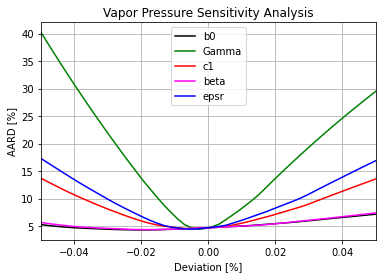

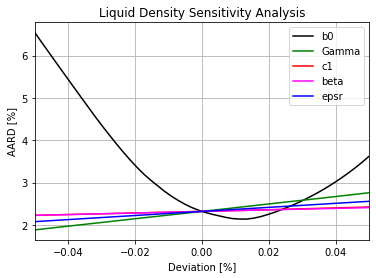

In [9]:
colors = ["black", "green", "red", "magenta",  "blue"]

for i in range(0,5):
    plt.plot(deltas,psat_deviation[:,i],color=colors[i])
plt.xlabel("Deviation [%]")
plt.ylabel("AARD [%]")
plt.legend(["b0", "Gamma", "c1", "beta", "epsr"])
plt.grid()
plt.xlim([np.min(deltas),np.max(deltas)])
plt.title("Vapor Pressure Sensitivity Analysis")
plt.show()

for i in range(0,5):
    plt.plot(deltas,rho_deviation[:,i],color=colors[i])
plt.xlabel("Deviation [%]")
plt.ylabel("AARD [%]")
plt.legend(["b0", "Gamma", "c1", "beta", "epsr"])
plt.grid()
plt.xlim([np.min(deltas),np.max(deltas)])
plt.title("Liquid Density Sensitivity Analysis")
plt.show()

In [10]:
#First, the thermodynamic calculations must be set up as per usua
Thermo = xt.xThermoInterface()

Tc = 769.5
Pc = 33.2
Om = 0.05

b0 = b0_new
Gamma = Gamma_new
c1 = c1_new

AssocEng =  AssocEng_new
AssocVol = AssocVol_new
AssocSch = 24

Thermo.NoPureComp(1)
Thermo.CritProps(1,Tc,Pc,Om)
Thermo.CPAParams(1,b0,Gamma,c1)
Thermo.AssocParams(1,AssocSch,AssocVol,AssocEng)


UncertaintyAnalysis = xt.CPA_UncertaintyAnalysis()


UncertaintyAnalysis.AddThermo(Thermo)


UncertaintyAnalysis.AddExp(exp_data)




data_matrix = UncertaintyAnalysis.Bootstrapping(50,enable_counter = True)

Iteration 1 of 50
Iteration 2 of 50
Iteration 3 of 50
Iteration 4 of 50
Iteration 5 of 50
Iteration 6 of 50
Iteration 7 of 50
Iteration 8 of 50
Iteration 9 of 50
Iteration 10 of 50
Iteration 11 of 50
Iteration 12 of 50
Iteration 13 of 50
Iteration 14 of 50
Iteration 15 of 50
Iteration 16 of 50
Iteration 17 of 50
Iteration 18 of 50
Iteration 19 of 50
Iteration 20 of 50
Iteration 21 of 50
Iteration 22 of 50
Iteration 23 of 50
Iteration 24 of 50
Iteration 25 of 50
Iteration 26 of 50
Iteration 27 of 50
Iteration 28 of 50
Iteration 29 of 50
Iteration 30 of 50
Iteration 31 of 50
Iteration 32 of 50
Iteration 33 of 50
Iteration 34 of 50
Iteration 35 of 50
Iteration 36 of 50
Iteration 37 of 50
Iteration 38 of 50
Iteration 39 of 50
Iteration 40 of 50
Iteration 41 of 50
Iteration 42 of 50
Iteration 43 of 50
Iteration 44 of 50
Iteration 45 of 50
Iteration 46 of 50
Iteration 47 of 50
Iteration 48 of 50
Iteration 49 of 50
Iteration 50 of 50


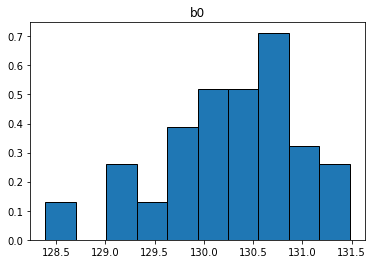

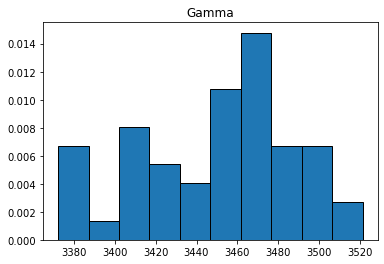

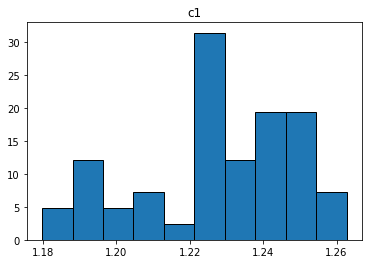

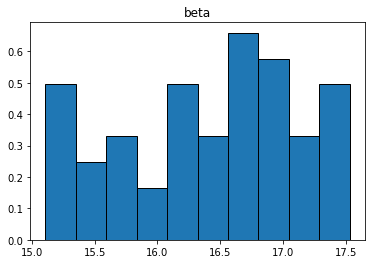

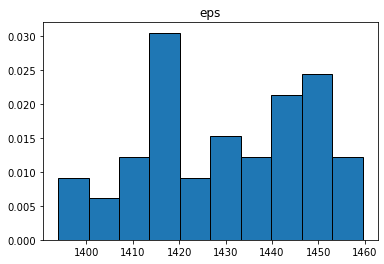

In [11]:
titles = ["b0","Gamma","c1", "beta", "eps"]

for i in range(0,5):
    plt.hist(data_matrix[:,i], density = True, edgecolor = 'black')
    plt.title(titles[i])
    plt.show()

dict_keys(['b0_vs_Gamma', 'b0_vs_c1', 'b0_vs_beta', 'b0_vs_eps', 'Gamma_vs_c1', 'Gamma_vs_beta', 'Gamma_vs_eps', 'c1_vs_beta', 'c1_vs_eps', 'beta_vs_eps'])


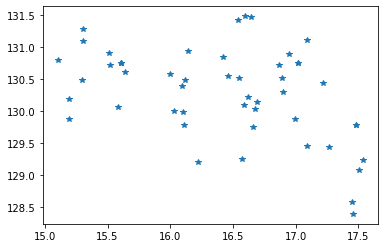

In [12]:
outputs = UncertaintyAnalysis.Scatter_Plots(data_matrix)
print(outputs.keys())
a = outputs["b0_vs_beta"]

plt.plot(a[:,0],a[:,1],'*')
plt.show()


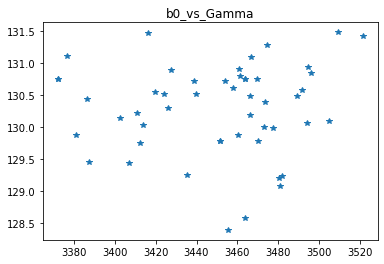

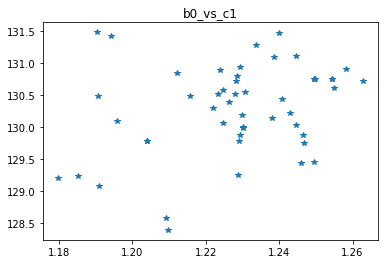

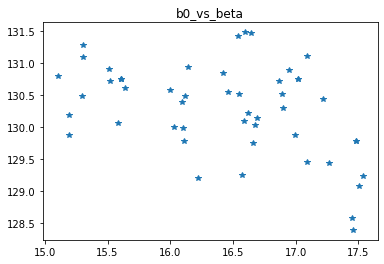

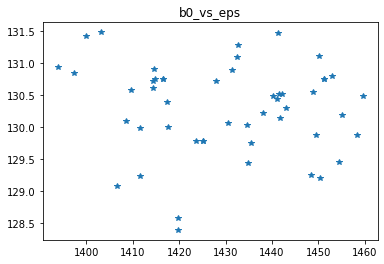

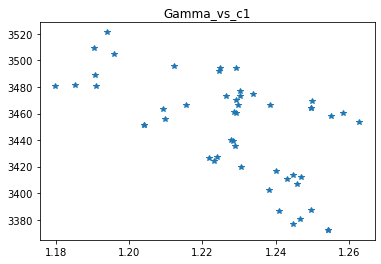

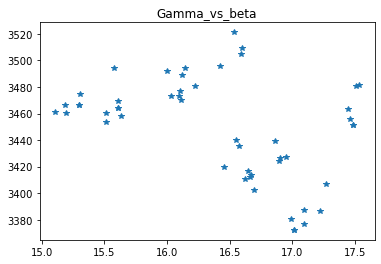

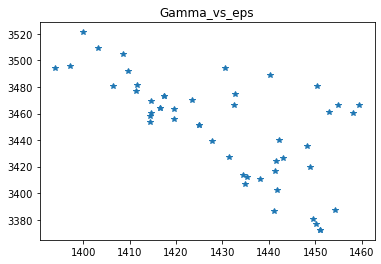

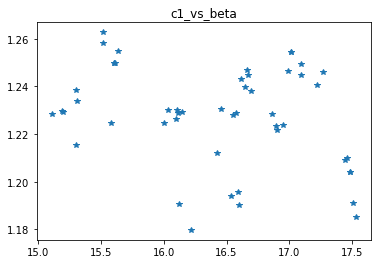

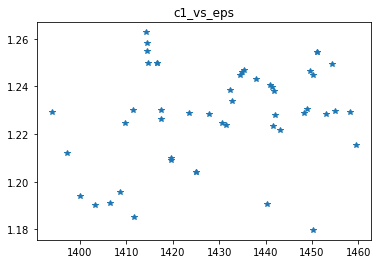

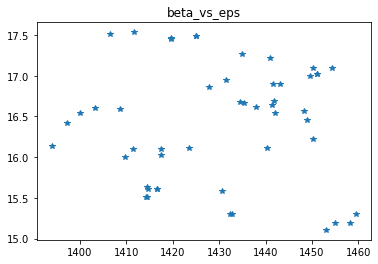

In [13]:
for str, values in outputs.items():
    plt.plot(values[:,0],values[:,1],'*')
    plt.title(str)
    plt.show()